In [17]:
import pandas as pd
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import warnings 
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [287]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

from sklearn.preprocessing import MinMaxScaler


def combine_features(arrays):
    x, y, z = arrays[0].shape[0], arrays[0].shape[1], len(arrays)
    reshaped = [a.reshape(x*y, 1) for a in arrays]
    return np.hstack(tuple(reshaped)).reshape(x, y, z)

def scale_data(tr, eval, tst, scaler=None):
    if scaler is not None:
        tr_pr = scaler.fit_transform(tr)
        eval_pr = scaler.transform(eval)
        tst_pr = scaler.transform(tst)

        return tr_pr, eval_pr, tst_pr, scaler
    else:
        return tr, eval, tst, None

def prepare_features(data, features, scaler=MinMaxScaler(feature_range=(-1, 1))):
    trains = []
    evals = []
    tests = []
    scalers = []
    for feature in features:
        tr, eval, tst, scl = scale_data(data[0][feature].fillna(0).values, 
                                        data[1][feature].fillna(0).values,
                                        data[2][feature].fillna(0).values,
                                        scaler=scaler)
        trains.append(tr)
        evals.append(eval)
        tests.append(tst)
        scalers.append(scl)

    tr = combine_features(trains)
    eval = combine_features(evals)
    tst = combine_features(tests)

    return tr, eval, tst, scalers

def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
             }
    return df.assign(**kwargs).drop(columns=[col_name])

# Data

In [3]:
dataPath = r'../data/cabspottingdata'
fileNames = [f for f in listdir(dataPath) if isfile(join(dataPath, f)) and 'txt' in f]

In [4]:
df = pd.DataFrame({'latitude':[], 
                   'longitude':[], 
                   'occupancy':[], 
                   'time':[],
                   'filename':[]})

for fileName in tqdm(fileNames):
    chunk = pd.read_csv(join(dataPath, fileName), sep=' ', header=None)
    chunk['filename'] = fileName
    chunk.columns = df.columns
    df = df.append(chunk, ignore_index=True)

100%|██████████| 537/537 [01:26<00:00,  6.20it/s]


In [5]:
df.sort_values(by=['filename', 'time'], inplace=True)

In [6]:
df['changed_trip_status'] = ((df.occupancy != df.occupancy.shift(1)) & 
                              df.occupancy.shift(1).notnull())*1
df['trip_number'] = df.groupby(['filename'])['changed_trip_status'].cumsum()

df['trip_distance'] = \
    haversine(df.latitude, df.longitude,
              df.groupby('filename')['latitude'].shift(1), 
              df.groupby('filename')['longitude'].shift(1))

df['trip_distance'] = df.groupby(['filename', 'trip_number'])['trip_distance'].cumsum().fillna(0)

In [255]:
tripData = \
  df.groupby(['filename', 'trip_number', 'occupancy'])\
    .agg({'latitude' : ['min', 'max'],
           'longitude' : ['min', 'max'],
           'time' : ['min', 'max'],
           'trip_distance' : 'max'
          })\
    .reset_index()

tripData.columns = ['filename', 'trip_number', 'occupancy', 'latitude_start',
                    'latitude_end', 'longitude_start', 'longitude_end', 
                    'start_time', 'end_time', 'trip_distance']

tripData['trip_dutation_seconds'] = tripData['end_time'] - tripData['start_time']
tripData = tripData[(tripData.trip_distance <= 30) & 
                    (tripData.trip_dutation_seconds <= 3600) & 
                    (tripData.occupancy == 1)]

In [277]:
n_timesteps = 32

In [257]:
lat_cols = []
lon_cols = []
for i in tqdm(range(0, n_timesteps+1)):
    tripData[f'latitude_lag_{i}'] = tripData.groupby('filename')['latitude_end'].shift(i)
    tripData[f'longitude_lag_{i}'] = tripData.groupby('filename')['longitude_end'].shift(i)
    if i <= 31:
        lat_cols.append(f'latitude_lag_{i}')
        lon_cols.append(f'longitude_lag_{i}')

lat_delta_cols = []
lon_delta_cols = []

for i in tqdm(range(0, n_timesteps)):
    tripData[f'latitude_delta_lag_{i}'] = tripData[f'latitude_lag_{i}'] - \
                                    tripData[f'latitude_lag_{i+1}']
    tripData[f'longitude_delta_lag_{i}'] = tripData[f'longitude_lag_{i}'] - \
                                    tripData[f'longitude_lag_{i+1}']

    lat_delta_cols.append(f'latitude_delta_lag_{i}')
    lon_delta_cols.append(f'longitude_delta_lag_{i}')


100%|██████████| 32/32 [00:00<00:00, 201.26it/s]


In [258]:
tripData[tripData.longitude_lag_32.notnull()].shape[0] / tripData.shape[0]

0.962709234736244

In [259]:
tripData['latitude_change'] = \
    tripData.groupby('filename')['latitude_start'].shift(-1) - \
        tripData['latitude_end']

In [260]:
tripData['longitude_change'] = \
    tripData.groupby('filename')['longitude_start'].shift(-1) - \
        tripData['longitude_end']

In [261]:
tripData['dt_start'] = pd.to_datetime(tripData['start_time'],unit='s')
tripData['dt_end'] = pd.to_datetime(tripData['end_time'],unit='s')

In [262]:
tripData['hour'] = tripData['dt_start'].dt.hour
tripData['day'] = tripData['dt_start'].dt.weekday

In [263]:
tripData = generate_cyclical_features(tripData, 'hour', 24, 0)
tripData = generate_cyclical_features(tripData, 'day', 7, 0)

In [264]:
tripData[['sin_hour', 'cos_hour', 'sin_day', 'cos_day']].head()

,sin_hour,cos_hour,sin_day,cos_day
1,-0.500000,-0.866025,-0.974928,-0.222521
3,-0.707107,-0.707107,-0.974928,-0.222521
5,-0.707107,-0.707107,-0.974928,-0.222521
7,-0.707107,-0.707107,-0.974928,-0.222521
9,-0.866025,-0.500000,-0.974928,-0.222521


In [265]:
sin_hour_cols, cos_hour_cols = [], []
sin_day_cols, cos_day_cols = [], []
for i in tqdm(range(0, n_timesteps)):
    tripData[f'sin_hour_lag_{i}'] = tripData.groupby('filename')['sin_hour'].shift(i)
    tripData[f'cos_hour_lag_{i}'] = tripData.groupby('filename')['cos_hour'].shift(i)
    tripData[f'sin_day_lag_{i}'] = tripData.groupby('filename')['sin_day'].shift(i)
    tripData[f'cos_day_lag_{i}'] = tripData.groupby('filename')['cos_day'].shift(i)
    sin_hour_cols.append(f'sin_hour_lag_{i}')
    cos_hour_cols.append(f'cos_hour_lag_{i}')
    sin_day_cols.append(f'sin_day_lag_{i}')
    cos_day_cols.append(f'cos_day_lag_{i}')

100%|██████████| 32/32 [00:05<00:00,  6.27it/s]


In [266]:
tripData = tripData[tripData.latitude_change.notnull() & 
                    tripData.longitude_change.notnull() & 
                    tripData.longitude_lag_32.notnull()]

In [267]:
tripData.head()

,filename,trip_number,occupancy,latitude_start,latitude_end,longitude_start,longitude_end,start_time,end_time,trip_distance,...,sin_day_lag_29,cos_day_lag_29,sin_hour_lag_30,cos_hour_lag_30,sin_day_lag_30,cos_day_lag_30,sin_hour_lag_31,cos_hour_lag_31,sin_day_lag_31,cos_day_lag_31
65,new_abboip.txt,65,1.0,37.76746,37.77133,-122.43869,-122.42917,1.211080e+09,1.211081e+09,1.120437,...,-0.974928,-0.222521,-0.707107,-0.707107,-0.974928,-0.222521,-0.707107,-0.707107,-0.974928,-0.222521
67,new_abboip.txt,67,1.0,37.74320,37.76257,-122.43492,-122.43124,1.211081e+09,1.211081e+09,2.477214,...,-0.974928,-0.222521,-0.707107,-0.707107,-0.974928,-0.222521,-0.707107,-0.707107,-0.974928,-0.222521
69,new_abboip.txt,69,1.0,37.75932,37.78118,-122.43496,-122.40131,1.211082e+09,1.211083e+09,4.598116,...,-0.974928,-0.222521,-0.866025,-0.500000,-0.974928,-0.222521,-0.707107,-0.707107,-0.974928,-0.222521
71,new_abboip.txt,71,1.0,37.76473,37.77349,-122.42104,-122.40173,1.211083e+09,1.211083e+09,2.520302,...,-0.974928,-0.222521,-0.866025,-0.500000,-0.974928,-0.222521,-0.866025,-0.500000,-0.974928,-0.222521
73,new_abboip.txt,73,1.0,37.77333,37.79041,-122.42379,-122.40521,1.211084e+09,1.211084e+09,3.450693,...,-0.974928,-0.222521,-0.965926,-0.258819,-0.974928,-0.222521,-0.866025,-0.500000,-0.974928,-0.222521


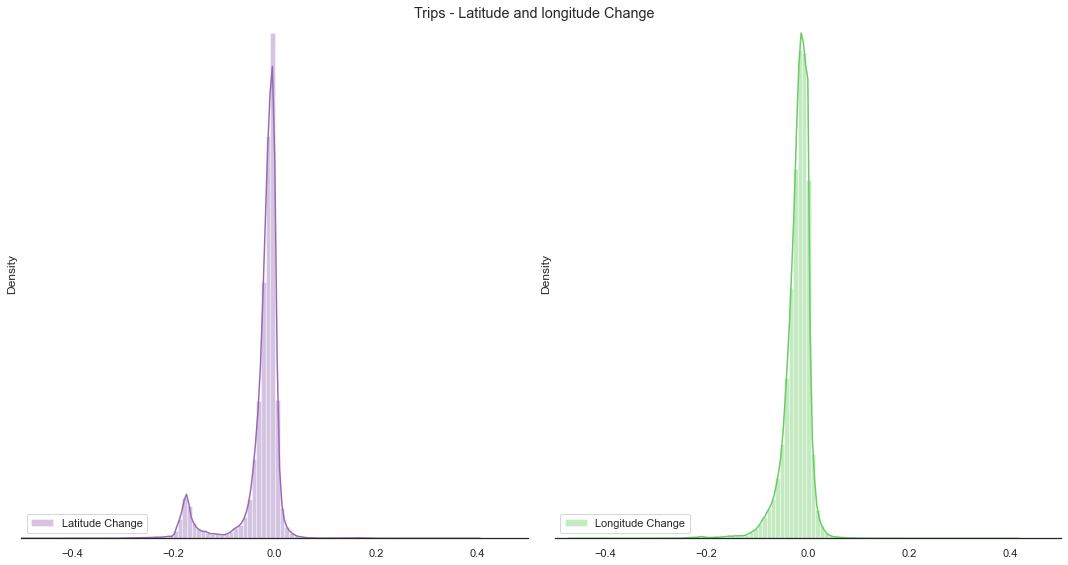

In [123]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1,2,figsize=(15, 8), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(tripData['latitude_change'].values, 
             label = 'Latitude Change',color="m",bins = 100, ax=axes[0])
sns.distplot(tripData['longitude_change'].values, 
             label = 'Longitude Change',color="g",bins =100, ax=axes[1])

plt.setp(axes, yticks=[])
plt.tight_layout()
axes[0].legend(loc='lower left')
axes[1].legend(loc='lower left')

axes[0].set_xlim([-0.5, 0.5])
axes[1].set_xlim([-0.5, 0.5])

plt.suptitle('Trips - Latitude and longitude Change')
plt.show()

# NN

### Data Preparation

In [268]:
targets = ['latitude_change', 'longitude_change']

features = [lat_cols, lon_cols, lat_delta_cols, lon_delta_cols,
            sin_hour_cols, cos_hour_cols, sin_day_cols, cos_day_cols
            ]

In [276]:
for f in features:
    assert len(f) == n_timesteps

In [288]:
trainData = tripData[(tripData.dt_start.dt.date < datetime.date(2008, 6, 6)) 
                      # & tripData[targets[0]].between(-0.1, 0.1)
                    ].sample(frac=1, random_state=0).reset_index()

evalData = tripData[ (tripData.dt_start.dt.date.between(datetime.date(2008, 6, 6),
                                                        datetime.date(2008, 6, 8)
                                                       ))
                    ].reset_index()

testData = tripData[(tripData.dt_start.dt.date > datetime.date(2008, 6, 8))
                    ].reset_index()

In [289]:
data = (trainData, evalData, testData)

In [290]:
trainData.shape, evalData.shape, testData.shape

((356437, 278), (67486, 278), (16100, 278))

In [291]:
train_data, eval_data, test_data, scalers = prepare_features(data, features)

In [292]:
train_data.shape

(356437, 32, 8)

In [293]:
train_data[0]

array([[ 3.70854361e-01, -5.25332132e-01, -4.42977504e-02,
        -1.03487590e-01,  2.58819045e-01,  9.65925826e-01,
         8.01937736e-01,  6.03875472e-01],
       [ 4.26854716e-01, -5.00000000e-01, -1.99774168e-03,
        -1.00933748e-01,  0.00000000e+00,  1.00000000e+00,
         8.01937736e-01,  6.03875472e-01],
       [ 4.25197200e-01, -4.78871125e-01, -1.48744897e-02,
        -1.05516982e-01,  0.00000000e+00,  1.00000000e+00,
         8.01937736e-01,  6.03875472e-01],
       [ 4.41091593e-01, -4.50198904e-01,  5.36350213e-02,
        -4.64821972e-02,  0.00000000e+00,  1.00000000e+00,
         8.01937736e-01,  6.03875472e-01],
       [ 3.63602729e-01, -5.18689484e-01,  1.36584730e-02,
        -3.20256296e-02, -7.07106781e-01,  7.07106781e-01,
         0.00000000e+00,  1.00000000e+00],
       [ 3.40604697e-01, -6.10973504e-01, -3.52427690e-02,
        -1.42775707e-01, -7.07106781e-01,  7.07106781e-01,
         0.00000000e+00,  1.00000000e+00],
       [ 3.84262479e-01, -5.209787

In [294]:
y_train_lat, y_eval_lat, y_test_lat, y_scaler_lat = \
    scale_data(trainData[targets[0]].values.reshape(-1, 1), 
           evalData[targets[0]].values.reshape(-1, 1),
           testData[targets[0]].values.reshape(-1, 1),
           scaler = None)

y_train_lon, y_eval_lon, y_test_lon, y_scaler_lon = \
    scale_data(trainData[targets[1]].values.reshape(-1, 1), 
           evalData[targets[1]].values.reshape(-1, 1),
           testData[targets[1]].values.reshape(-1, 1),
           scaler = None)

### RNN

In [279]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.autograd import Variable

In [295]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length, batch_size):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 80 # number of hidden states
        self.n_layers = 2 # number of LSTM layers (stacked)
        self.batch_size = batch_size
        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 1)
        
    
    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        w_h = torch.empty(self.n_layers,batch_size,self.n_hidden)
        w_c = torch.empty(self.n_layers,batch_size,self.n_hidden)
        hidden_state = torch.nn.init.xavier_uniform(w_h).requires_grad_().to(device)
        cell_state = torch.nn.init.xavier_uniform(w_c).requires_grad_().to(device)
        self.hidden = (hidden_state, cell_state)
    
    
    def forward(self, x):        
        batch_size, seq_len, _ = x.size()
        
        lstm_out, self.hidden = self.l_lstm(x, self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1).to(x.device)
        return self.l_linear(x)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        model.init_hidden(model.batch_size)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        total_loss += loss

    avg_loss = total_loss / size
    print(f"Train Loss: {avg_loss}")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            
    test_loss /= size
    print(f"Test Loss: {test_loss}")
    return test_loss

def array_padding(input_data, batch_size = 64):
    if input_data.shape[0] % batch_size == 0:
        return input_data
    right_size = batch_size + batch_size*(len(input_data) // batch_size)
    shape = list(input_data.shape)
    shape[0] = right_size - input_data.shape[0]
    empty_array = np.zeros(tuple(shape))
    return np.vstack((input_data, empty_array))


In [281]:
n_features = train_data.shape[2] # this is number of parallel inputs
batch_size = 2**6

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Latitude NN

In [296]:
train_dataloader = DataLoader(TensorDataset(torch.Tensor(train_data), 
                               torch.Tensor(y_train_lat)), 
                              batch_size=batch_size,
                              drop_last=True, 
                              shuffle=True)
eval_dataloader = DataLoader(TensorDataset(torch.Tensor(eval_data), 
                               torch.Tensor(y_eval_lat)), 
                              batch_size=batch_size,
                              drop_last=True, 
                              shuffle=True)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

model = MV_LSTM(n_features,n_timesteps, batch_size).to(device)
loss_fn = torch.nn.MSELoss(reduction="sum") # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

epochs = 10**3
best_loss = np.inf
stop_rounds = 1
current_rounds = 0
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    loss_ = test(eval_dataloader, model, loss_fn)
    if loss_ > best_loss:
        current_rounds += 1
        if current_rounds >= stop_rounds:
            break
    else:
        best_loss = loss_
print("Done!")


torch.save(model.state_dict(), "../models/rnn/rnn_latitude.pth")

Shape of X [N, C, H, W]: torch.Size([64, 32, 8])
Shape of y: torch.Size([64, 1]) torch.float32
Epoch 1
-------------------------------
loss: 0.587589  [    0/356437]
loss: 0.099965  [64000/356437]
loss: 0.251111  [128000/356437]
loss: 0.143270  [192000/356437]
loss: 0.132931  [256000/356437]
loss: 0.155795  [320000/356437]
Train Loss: 0.002265482908114791
Test Loss: 0.002294884017624697
Epoch 2
-------------------------------
loss: 0.113687  [    0/356437]
loss: 0.199735  [64000/356437]
loss: 0.163984  [128000/356437]
loss: 0.147046  [192000/356437]
loss: 0.109948  [256000/356437]
loss: 0.165656  [320000/356437]
Train Loss: 0.0022413816768676043
Test Loss: 0.00209327579851002
Epoch 3
-------------------------------
loss: 0.183861  [    0/356437]
loss: 0.155709  [64000/356437]
loss: 0.222639  [128000/356437]
loss: 0.095863  [192000/356437]
loss: 0.193511  [256000/356437]
loss: 0.146138  [320000/356437]
Train Loss: 0.0022347834892570972
Test Loss: 0.002025289045326014
Epoch 4
-----------

In [304]:
test_dataloader = DataLoader(TensorDataset(
                               torch.Tensor(array_padding(test_data, batch_size = batch_size)), 
                               torch.Tensor(array_padding(y_test_lat, batch_size = batch_size))), 
                              batch_size=batch_size)

predictions = []
for X, y in test_dataloader:
    pred = model(X.to(device)).cpu().detach().numpy()
    predictions.extend(pred)

predictions = np.array([p[0] for p in predictions[:test_data.shape[0]]]).reshape(-1, 1)

if y_scaler_lat is not None:
    testData['lat_prediction_rnn'] = y_scaler_lat.inverse_transform(predictions)
else:
    print('No target scaling required')
    testData['lat_prediction_rnn'] = predictions

No target scaling required


In [305]:
testData['lat_prediction_rnn'] = testData['lat_prediction_rnn'] - (testData['lat_prediction_rnn'].mean())

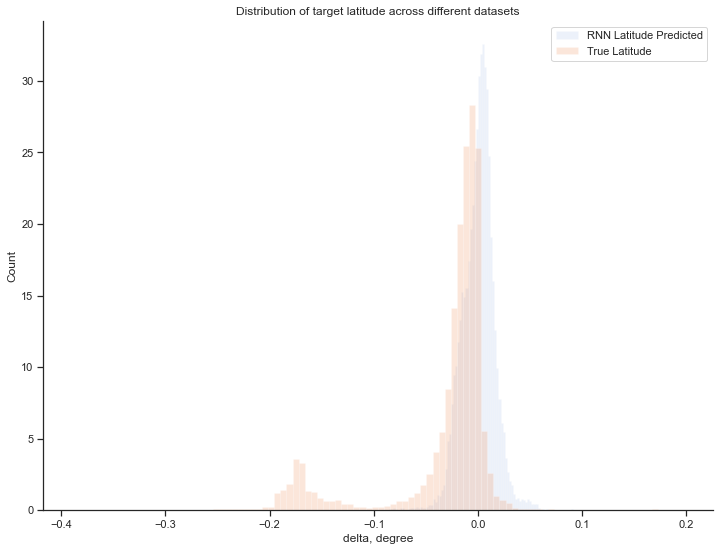

In [306]:
plt.figure(figsize=(12, 9))  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.xlabel("delta, degree")  
plt.ylabel("Count")  

plt.hist(testData['lat_prediction_rnn'], 
         bins=100, label = 'RNN Latitude Predicted', alpha=0.1, density=True)

plt.hist(testData[targets[0]], 
         bins=100, label = 'True Latitude', alpha=0.2, density=True)

plt.title('Distribution of target latitude across different datasets')
# plt.xlim([-0.9, 0.9])
plt.legend()
plt.show()

In [307]:
testData[['lat_prediction_rnn', targets[0]]].describe()

,lat_prediction_rnn,latitude_change
count,1.610000e+04,16100.000000
mean,-2.876572e-08,-0.031644
std,1.556630e-02,0.053813
min,-1.069361e-01,-0.388260
25%,-9.457924e-03,-0.028550
50%,1.316043e-03,-0.013240
75%,9.289828e-03,-0.003970
max,9.077619e-02,0.195830


### Longitude NN

In [309]:
train_dataloader = DataLoader(TensorDataset(torch.Tensor(train_data), 
                               torch.Tensor(y_train_lon)), 
                              batch_size=batch_size,
                              drop_last=True, 
                              shuffle=True)
eval_dataloader = DataLoader(TensorDataset(torch.Tensor(eval_data), 
                               torch.Tensor(y_eval_lon)), 
                              batch_size=batch_size,
                              drop_last=True, 
                              shuffle=True)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

model = MV_LSTM(n_features,n_timesteps, batch_size).to(device)
loss_fn = torch.nn.MSELoss(reduction="sum") # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

epochs = 10**3
best_loss = np.inf
stop_rounds = 1
current_rounds = 0
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    loss_ = test(eval_dataloader, model, loss_fn)
    if loss_ > best_loss:
        current_rounds += 1
        if current_rounds >= stop_rounds:
            break
    else:
        best_loss = loss_
print("Done!")


torch.save(model.state_dict(), "../models/rnn/rnn_longitude.pth")

Shape of X [N, C, H, W]: torch.Size([64, 32, 8])
Shape of y: torch.Size([64, 1]) torch.float32
Epoch 1
-------------------------------
loss: 0.162697  [    0/356437]
loss: 0.033451  [64000/356437]
loss: 0.016084  [128000/356437]
loss: 0.027126  [192000/356437]
loss: 0.023761  [256000/356437]
loss: 0.027825  [320000/356437]
Train Loss: 0.00048657311708666384
Test Loss: 0.000662650237478665
Epoch 2
-------------------------------
loss: 0.038122  [    0/356437]
loss: 0.031747  [64000/356437]
loss: 0.025125  [128000/356437]
loss: 0.021046  [192000/356437]
loss: 0.045866  [256000/356437]
loss: 0.020675  [320000/356437]
Train Loss: 0.00044598724343813956
Test Loss: 0.0008018845907560601
Done!


In [310]:
test_dataloader = DataLoader(TensorDataset(
                               torch.Tensor(array_padding(test_data, batch_size = batch_size)), 
                               torch.Tensor(array_padding(y_test_lon, batch_size = batch_size))), 
                              batch_size=batch_size)

predictions = []
for X, y in test_dataloader:
    pred = model(X.to(device)).cpu().detach().numpy()
    predictions.extend(pred)

predictions = np.array([p[0] for p in predictions[:test_data.shape[0]]]).reshape(-1, 1)

if y_scaler_lat is not None:
    testData['lon_prediction_rnn'] = y_scaler_lat.inverse_transform(predictions)
else:
    print('No target scaling required')
    testData['lon_prediction_rnn'] = predictions

No target scaling required


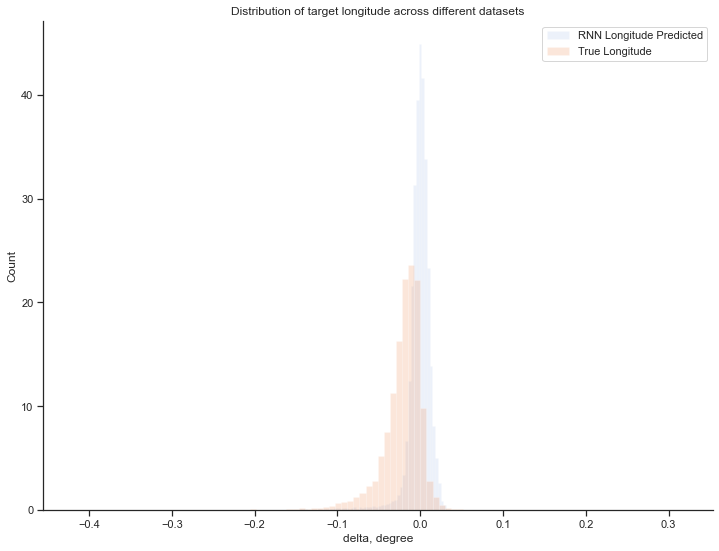

In [311]:
plt.figure(figsize=(12, 9))  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.xlabel("delta, degree")  
plt.ylabel("Count")  

plt.hist(testData['lon_prediction_rnn'], 
         bins=100, label = 'RNN Longitude Predicted', alpha=0.1, density=True)

plt.hist(testData[targets[1]], 
         bins=100, label = 'True Longitude', alpha=0.2, density=True)

plt.title('Distribution of target longitude across different datasets')
# plt.xlim([-0.9, 0.9])
plt.legend()
plt.show()

In [312]:
testData[['lon_prediction_rnn', targets[1]]].describe()

,lon_prediction_rnn,longitude_change
count,16100.000000,16100.000000
mean,-0.001977,-0.021788
std,0.016482,0.026636
min,-0.295192,-0.419090
25%,-0.006417,-0.030680
50%,-0.000127,-0.016760
75%,0.005854,-0.006100
max,0.034393,0.316390


In [317]:
preds = testData[['filename', 'trip_number', 'latitude_start', 'latitude_end',
                  'longitude_start', 'longitude_end', 
                  'lat_prediction_rnn', 'lon_prediction_rnn',
                  'latitude_change', 'longitude_change']].copy()

In [318]:
preds['latitude_rnn_predicted'] = preds['latitude_end'] + preds['lat_prediction_rnn']
preds['latitude_true'] = preds['latitude_end'] + preds['latitude_change']


preds['longitude_rnn_predicted'] = preds['longitude_end'] + preds['lon_prediction_rnn']
preds['longitude_true'] = preds['longitude_end'] + preds['longitude_change']

In [319]:
preds.to_csv(r'../predictions/rnn_predictions.csv', index=False)